# Start-to-Finish Example: [TOV](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) Neutron Star Simulation: The "Hydro without Hydro" Test

## Authors: Zach Etienne & Phil Chang
### Formatting improvements courtesy Brandon Clark

## This module sets up initial data for a neutron star on a spherical numerical grid, using the approach [documented in the previous NRPy+ module](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb), and then evolves these initial data forward in time. The aim is to reproduce the results from [Baumgarte, Hughes, and Shapiro]( https://arxiv.org/abs/gr-qc/9902024) (which were performed using Cartesian grids); demonstrating that the extrinsic curvature and Hamiltonian constraint violation converge to zero with increasing numerical resolution

<font color='green'>**This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution (see [plot](#convergence) at bottom). Note that convergence in the region causally influenced by the surface of the star will possess lower convergence order due to the sharp drop to zero in $T^{\mu\nu}$.**</font>

### NRPy+ Source Code for this module: 

* [TOV/TOV_Solver.py](../edit/TOV/TOV_Solver.py); ([**NRPy+ Tutorial module reviewing mathematical formulation and equations solved**](Tutorial-ADM_Initial_Data-TOV.ipynb)); ([**start-to-finish NRPy+ Tutorial module demonstrating that initial data satisfy Hamiltonian constraint**](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_TOV_initial_data.ipynb)): Tolman-Oppenheimer-Volkoff (TOV) initial data; defines all ADM variables and nonzero $T^{\mu\nu}$ components in Spherical basis.
* [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb): *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function
* [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates

## Introduction:
Here we use NRPy+ to generate initial data for a [simple polytrope TOV star](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data (**This module**).</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate BSSN RHS expressions.</font>
    1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
    1. <font color='green'>Apply constraints on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$</font>
1. At the end of each iteration in time, output the <font color='green'>Hamiltonian constraint violation</font>.
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
1. [Step 2](#adm_id_tov): Set up ADM initial data for polytropic TOV Star
    1. [Step 2.a](#tov_interp): Interpolating the TOV data file as needed
    1. [Step 2.b](#source): Compute source terms $S_{ij}$, $S_{i}$, $S$, and $\rho$
    1. [Step 2.c](#jacobian): Jacobian transformation on the ADM/BSSN source terms
    1. [Step 2.d](#tensor): Rescale tensorial quantities
1. [Step 3](#adm_id_spacetime): Take care of the ADM spacetime quantity initial data conversion
1. [Step 4](#bssn_source): Set up the BSSN right-hand-side (RHS) expressions, and add the *rescaled* $T^{\mu\nu}$ source terms
1. [Step 5](#hydro_hydro): Validating "Hydro without Hydro" test satisfies the Hamiltonian constraint
    1. [Step 5.a](#ham_const_output): Output the Hamiltonian Constraint
    1. [Step 5.b](#apply_bcs): Apply singular, curvilinear coordinate boundary conditions
    1. [Step 5.c](#enforce3metric): Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint
1. [Step 6](#mainc): TOV_Playground.c: The Main C Code
1. [Step 7](#visual): Data Visualization Animations
1. [Step 8](#convergence): Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero
1. [Step 9](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$


In [1]:
# First we import needed core NRPy+ modules
from outputC import *
import NRPy_param_funcs as par
import grid as gri
import loop as lp
import indexedexp as ixp
import finite_difference as fin
import reference_metric as rfm
import BSSN.BSSN_quantities as Bq
import BSSN.BSSN_RHSs as rhs
import BSSN.BSSN_gauge_RHSs as gaugerhs
import BSSN.BSSN_T4UUmunu_vars as BTmunu

thismodule = "TOV_ID_setup"

# Set spatial dimension (must be 3 for BSSN)
DIM = 3
par.set_parval_from_str("grid::DIM",DIM)

# Then we set the coordinate system for the numerical grid
par.set_parval_from_str("reference_metric::CoordSystem","Spherical")
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Then we set the phi axis to be the symmetry axis; i.e., axis "2", corresponding to the i2 direction. 
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")

# We will need the h_{ij} quantities defined within BSSN_RHSs 
#    below when we enforce the gammahat=gammabar constraint
par.set_parval_from_str("BSSN.BSSN_quantities::EvolvedConformalFactor_cf","W")

par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::ShiftEvolutionOption", "Frozen")
par.set_parval_from_str("BSSN.BSSN_gauge_RHSs::LapseEvolutionOption", "HarmonicSlicing")
rhs.BSSN_RHSs()
gaugerhs.BSSN_gauge_RHSs()

#################
# Next output C headers related to the numerical grids we just set up:
#################

# First output the coordinate bounds xxmin[] and xxmax[]:
with open("BSSN/xxminmax.h", "w") as file:
    file.write("const REAL xxmin[3] = {"+str(rfm.xxmin[0])+","+str(rfm.xxmin[1])+","+str(rfm.xxmin[2])+"};\n")
    file.write("const REAL xxmax[3] = {"+str(rfm.xxmax[0])+","+str(rfm.xxmax[1])+","+str(rfm.xxmax[2])+"};\n")

# Generic coordinate NRPy+ file output, Part 2: output the conversion from (x0,x1,x2) to Cartesian (x,y,z)
outputC([rfm.xxCart[0],rfm.xxCart[1],rfm.xxCart[2]],["xCart[0]","xCart[1]","xCart[2]"],
        "BSSN/xxCart.h")

# Next output the proper distance between gridpoints in given coordinate system.
#     This is used to find the minimum timestep.
dxx     = ixp.declarerank1("dxx",DIM=3)
ds_dirn = rfm.ds_dirn(dxx)
outputC([ds_dirn[0],ds_dirn[1],ds_dirn[2]],["ds_dirn0","ds_dirn1","ds_dirn2"],"BSSN/ds_dirn.h")

# Register the Hamiltonian as a gridfunction, to be used later.
H = gri.register_gridfunctions("AUX","H")

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Wrote to file "BSSN/xxCart.h"
Wrote to file "BSSN/ds_dirn.h"


<a id='adm_id_tov'></a>

# Step 2: Set up ADM initial data for polytropic TOV Star \[Back to [top](#toc)\]
$$\label{adm_id_tov}$$

As documented [in the TOV Initial Data NRPy+ Tutorial Module](Tutorial-TOV_Initial_Data.ipynb) ([older version here](Tutorial-GRMHD_UnitConversion.ipynb)), we will now set up TOV initial data, storing the densely-sampled result to file (***Courtesy Phil Chang***).

The TOV solver uses an ODE integration routine provided by scipy, so we first make sure that scipy is installed:

In [2]:
!pip install scipy > /dev/null

Next we call the [TOV.TOV_Solver() function](../edit/TOV/TOV_Solver.py) ([NRPy+ Tutorial module](Tutorial-ADM_Initial_Data-TOV.ipynb)) to set up the initial data, using the default parameters for initial data. This function outputs the solution to a file named "outputTOVpolytrope.txt".

In [3]:
import TOV.TOV_Solver as TOV
TOV.TOV_Solver()

Just generated a TOV star with R_Schw = 0.9565681425227097 , M = 0.14050303285288188 , M/R_Schw = 0.1468824086931645 .


<a id='tov_interp'></a>

## Step 2.a: Interpolating the TOV data file as needed \[Back to [top](#toc)\]
$$\label{tov_interp}$$

The TOV data file just written stored $\left(r,\rho(r),P(r),M(r),e^{\nu(r)}\right)$, where $\rho(r)$ is the total mass-energy density (cf. $\rho_{\text{baryonic}}$).

**METRIC DATA IN TERMS OF ADM QUANTITIES**

The [TOV line element](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation) in *Schwarzschild coordinates* is written (in the $-+++$ form):
$$
ds^2 = - c^2 e^\nu dt^2 + \left(1 - \frac{2GM}{rc^2}\right)^{-1} dr^2 + r^2 d\Omega^2.
$$

In *isotropic coordinates* with $G=c=1$ (i.e., the coordinate system we'd prefer to use), the ($-+++$ form) line element is written:
$$
ds^2 = - e^{\nu} dt^2 + e^{4\phi} \left(d\bar{r}^2 + \bar{r}^2 d\Omega^2\right),
$$
where $\phi$ here is the *conformal factor*.

The ADM 3+1 line element for this diagonal metric in isotropic spherical coordinates is given by:
$$
ds^2 = (-\alpha^2 + \beta_k \beta^k) dt^2 + \gamma_{\bar{r}\bar{r}} d\bar{r}^2 + \gamma_{\theta\theta} d\theta^2+ \gamma_{\phi\phi} d\phi^2,
$$

from which we can immediately read off the ADM quantities:
\begin{align}
\alpha &= e^{\nu(\bar{r})/2} \\
\beta^k &= 0 \\
\gamma_{\bar{r}\bar{r}} &= e^{4\phi}\\
\gamma_{\theta\theta} &= e^{4\phi} \bar{r}^2 \\
\gamma_{\phi\phi} &= e^{4\phi} \bar{r}^2 \sin^2 \theta \\
\end{align}

**STRESS-ENERGY TENSOR $T^{\mu\nu}$**

We will also need the stress-energy tensor $T^{\mu\nu}$. [As discussed here](https://en.wikipedia.org/wiki/Tolman%E2%80%93Oppenheimer%E2%80%93Volkoff_equation), the stress-energy tensor is diagonal:

\begin{align}
T^t_t &= -\rho \\
T^i_j &= P \delta^i_j \\
\text{All other components of }T^\mu_\nu &= 0.
\end{align}

Since $\beta^i=0$ the inverse metric expression simplifies to (Eq. 4.49 in [Gourgoulhon](https://arxiv.org/pdf/gr-qc/0703035.pdf)):
$$
g^{\mu\nu} = \begin{pmatrix} 
-\frac{1}{\alpha^2} & \frac{\beta^i}{\alpha^2} \\
\frac{\beta^i}{\alpha^2} & \gamma^{ij} - \frac{\beta^i\beta^j}{\alpha^2}
\end{pmatrix} =
\begin{pmatrix} 
-\frac{1}{\alpha^2} & 0 \\
0 & \gamma^{ij}
\end{pmatrix},
$$

and since the 3-metric is diagonal we get

\begin{align}
\gamma^{\bar{r}\bar{r}} &= e^{-4\phi}\\
\gamma^{\theta\theta} &= e^{-4\phi}\frac{1}{\bar{r}^2} \\
\gamma^{\phi\phi} &= e^{-4\phi}\frac{1}{\bar{r}^2 \sin^2 \theta}.
\end{align}

Thus raising $T^\mu_\nu$ yields a diagonal $T^{\mu\nu}$

\begin{align}
T^{tt} &= -g^{tt} \rho = \frac{1}{\alpha^2} \rho = e^{-\nu(\bar{r})} \rho \\
T^{\bar{r}\bar{r}} &= g^{\bar{r}\bar{r}} P = \frac{1}{e^{4 \phi}} P \\
T^{\theta\theta} &= g^{\theta\theta} P = \frac{1}{e^{4 \phi}\bar{r}^2} P\\
T^{\phi\phi} &= g^{\phi\phi} P = \frac{1}{e^{4\phi}\bar{r}^2 \sin^2 \theta} P 
\end{align}

As all input quantities are functions of $r$, we will simply read the solution from file and interpolate it to the values of $r$ needed by the initial data.

1. First we define functions ID_TOV_ADM_quantities() and ID_TOV_TUPMUNU() that call the [1D TOV interpolator function](../edit/TOV/tov_interp.h) to evaluate the ADM spacetime quantities and $T^{\mu\nu}$, respectively, at any given point $(r,\theta,\phi)$ in the Spherical basis. All quantities are defined as above.
1. Next we will construct the BSSN/ADM source terms $\{S_{ij},S_{i},S,\rho\}$ in the Spherical basis
1. Then we will perform the Jacobian transformation on $\{S_{ij},S_{i},S,\rho\}$ to the desired (xx0,xx1,xx2) basis
1. Next we call the *Numerical* Spherical ADM$\to$Curvilinear BSSN converter function to conver the above ADM quantities to the rescaled BSSN quantities in the desired curvilinear coordinate system: [BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py](../edit/BSSN/ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [4]:
with open("BSSN/ID_TOV_ADM_quantities.h", "w") as file:
    file.write("""
// This function takes as input either (x,y,z) or (r,th,ph) and outputs
//   all ADM quantities in the Cartesian or Spherical basis, respectively.
void ID_TOV_ADM_quantities(
                     const REAL xyz_or_rthph[3], 
                     
                     const ID_inputs other_inputs,
                     
                     REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                     REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                     REAL *alpha,
                     REAL *betaU0,REAL *betaU1,REAL *betaU2,
                     REAL *BU0,REAL *BU1,REAL *BU2) {
      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];

      REAL rho,P,M,expnu,exp4phi;
      TOV_interpolate_1D(r,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,  
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,  
                         &rho,&P,&M,&expnu,&exp4phi);
    
      *alpha = sqrt(expnu);
      // \gamma_{rbar rbar} = exp(4 phi)
      *gammaDD00 = exp4phi;
      // \gamma_{thth} = r^2 * exp(4 phi)
      *gammaDD11 = r*r * exp4phi;
      // \gamma_{phph} = r^2 sin^2(th) * exp(4 phi)
      *gammaDD22 = r*r*sin(th)*sin(th) * exp4phi;
      
      // All other quantities ARE ZERO:
      *gammaDD01 = 0.0;
      *gammaDD02 = 0.0;
      *gammaDD12 = 0.0;
      
      *KDD00 = 0.0;
      *KDD01 = 0.0;
      *KDD02 = 0.0;
      *KDD11 = 0.0;
      *KDD12 = 0.0;
      *KDD22 = 0.0;
      
      *betaU0 = 0.0;
      *betaU1 = 0.0;
      *betaU2 = 0.0;
      
      *BU0 = 0.0;
      *BU1 = 0.0;
      *BU2 = 0.0;
}\n""")

with open("BSSN/ID_TOV_TUPMUNU.h", "w") as file:
    file.write("""
// This function takes as input either (x,y,z) or (r,th,ph) and outputs
//   all ADM quantities in the Cartesian or Spherical basis, respectively.
void ID_TOV_TUPMUNU(const REAL xyz_or_rthph[3], const ID_inputs other_inputs,
                    
                    REAL *T4UU00,REAL *T4UU01,REAL *T4UU02,REAL *T4UU03,
                    /**/         REAL *T4UU11,REAL *T4UU12,REAL *T4UU13,
                    /**/                      REAL *T4UU22,REAL *T4UU23,
                    /**/                                   REAL *T4UU33) {
      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];

      REAL rho,P,M,expnu,exp4phi;
      TOV_interpolate_1D(r,other_inputs.Rbar,other_inputs.Rbar_idx,other_inputs.interp_stencil_size,  
                         other_inputs.numlines_in_file,
                         other_inputs.r_Schw_arr,other_inputs.rho_arr,other_inputs.P_arr,other_inputs.M_arr,
                         other_inputs.expnu_arr,other_inputs.exp4phi_arr,other_inputs.rbar_arr,
                         &rho,&P,&M,&expnu,&exp4phi);

      //T^tt = e^(-nu) * rho
      *T4UU00 = rho / expnu;
      //T^rr = P / exp4phi
      *T4UU11 = P / exp4phi;
      //T^thth = P / (r^2 * exp4phi)
      *T4UU22 = P / (r*r * exp4phi);
      //T^phph = P / (r^2 * sin^2(th) * exp4phi)
      *T4UU33 = P / (r*r * sin(th)*sin(th) * exp4phi);

      // All other components ARE ZERO:
      *T4UU01 = 0; *T4UU02 = 0; *T4UU03 = 0;
      /**/         *T4UU12 = 0; *T4UU13 = 0;
      /**/                      *T4UU23 = 0;
}\n""")

<a id='source'></a>

## Step 2.b: Compute source terms $S_{ij}$, $S_{i}$, $S$, and $\rho$ \[Back to [top](#toc)\]
$$\label{source}$$

We compute source terms $S_{ij}$, $S_{i}$, $S$, and $\rho$, via Eqs. 10 of [Baumgarte, Montero, Cordero-Carrión, and Müller](https://arxiv.org/pdf/1211.6632.pdf):

\begin{array}
\ S_{ij} &= \gamma_{i \mu} \gamma_{j \nu} T^{\mu \nu} \\
S_{i} &= -\gamma_{i\mu} n_\nu T^{\mu\nu} \\
S &= \gamma^{ij} S_{ij} \\
\rho &= n_\mu n_\nu T^{\mu\nu},
\end{array}

ID_TOV_TUPMUNU() provides numerical values for $T^{\mu\nu}$, but we do not have $\gamma_{\mu \nu}$ or $n_\mu$ directly. So here we will construct the latter quantities.

First, B&S Eq. 2.27 defines $\gamma_{\mu \nu}$ as:

$$\gamma_{\mu\nu} = g_{\mu\nu} + n_\mu n_\nu$$

where 

$$
n_\mu = \{-\alpha,0,0,0\}.
$$

So we will first need to construct the 4-metric based on ADM quantities. This is provided by Eq 4.47 in [Gourgoulhon](https://arxiv.org/pdf/gr-qc/0703035.pdf):
$$
g_{\mu\nu} = \begin{pmatrix} 
-\alpha^2 + \beta^k \beta_k & \beta_i \\
\beta_j & \gamma_{ij}
\end{pmatrix}.
$$

In [5]:
gammaDD = ixp.declarerank2("gammaDD", "sym01",DIM=3)
betaU   = ixp.declarerank1("betaU",DIM=3)
alpha   = sp.symbols("alpha")

# To get \gamma_{\mu \nu} = gammabar4DD[mu][nu], we'll need to construct the 4-metric, using Eq. 2.122 in B&S:

# Eq. 2.121 in B&S
betaD = ixp.zerorank1()
for i in range(DIM):
    for j in range(DIM):
        betaD[i] += gammaDD[i][j]*betaU[j]

# Now compute the beta contraction.
beta2 = sp.sympify(0)
for i in range(DIM):
    beta2 += betaU[i]*betaD[i]

# Eq. 2.122 in B&S
g4DD = ixp.zerorank2(DIM=4)
g4DD[0][0] = -alpha**2 + beta2
for i in range(DIM):
    g4DD[i+1][0] = g4DD[0][i+1] = betaD[i]
for i in range(DIM):
    for j in range(DIM):
        g4DD[i+1][j+1] = gammaDD[i][j]

Now let's construct $\gamma_{\mu\nu}$=gamma4DD\[mu\]\[nu\] via $\gamma_{\mu\nu} = g_{\mu\nu} + n_\mu n_\nu$:

In [6]:
n4D = ixp.zerorank1(DIM=4)
n4D[0] = -alpha

gamma4DD = ixp.zerorank2(DIM=4)
for mu in range(4):
    for nu in range(4):
        gamma4DD[mu][nu] = g4DD[mu][nu] + n4D[mu]*n4D[nu]

We now have all we need to construct the BSSN source terms in the current basis (for TOV, the Spherical basis):

\begin{array}
\ S_{ij} &= \gamma_{i \mu} \gamma_{j \nu} T^{\mu \nu} \\
S_{i} &= -\gamma_{i\mu} n_\nu T^{\mu\nu} \\
S &= \gamma^{ij} S_{ij} \\
\rho &= n_\mu n_\nu T^{\mu\nu},
\end{array}

In [7]:
T4UU = ixp.declarerank2("T4UU", "sym01",DIM=4)

SDD = ixp.zerorank2()
SD  = ixp.zerorank1()
S   = sp.sympify(0)
rho = sp.sympify(0)

for i in range(DIM):
    for j in range(DIM):
        for mu in range(4):
            for nu in range(4):
                SDD[i][j] += gamma4DD[i+1][mu]*gamma4DD[j+1][nu] * T4UU[mu][nu]

for i in range(DIM):
    for mu in range(4):
        for nu in range(4):
            SD[i] += -gamma4DD[i+1][mu]*n4D[nu] * T4UU[mu][nu]

gammaUU, gammaDET = ixp.symm_matrix_inverter3x3(gammaDD)
for i in range(DIM):
    for j in range(DIM):
        S += gammaUU[i][j]*SDD[i][j]

for mu in range(4):
    for nu in range(4):
        rho += n4D[mu]*n4D[nu] * T4UU[mu][nu]

<a id='jacobian'></a>

## Step 2.c: Jacobian transformation on the ADM/BSSN source terms \[Back to [top](#toc)\]
$$\label{jacobian}$$

The following discussion holds for either Spherical or Cartesian input data, so for simplicity let's just assume the data are given in Spherical coordinates.

All ADM tensors and vectors are in the Spherical coordinate basis $x^i_{\rm Sph} = (r,\theta,\phi)$, but we need them in the curvilinear coordinate basis $x^i_{\rm rfm}= ({\rm xx0},{\rm xx1},{\rm xx2})$ set by the "reference_metric::CoordSystem" variable. Empirically speaking, it is far easier to write $(x({\rm xx0},{\rm xx1},{\rm xx2}),y({\rm xx0},{\rm xx1},{\rm xx2}),z({\rm xx0},{\rm xx1},{\rm xx2}))$ than the inverse, so we will compute the Jacobian matrix

$$
{\rm Jac\_dUSph\_dDrfmUD[i][j]} = \frac{\partial x^i_{\rm Sph}}{\partial x^j_{\rm rfm}},
$$

via exact differentiation (courtesy SymPy), and the inverse Jacobian
$$
{\rm Jac\_dUrfm\_dDSphUD[i][j]} = \frac{\partial x^i_{\rm rfm}}{\partial x^j_{\rm Sph}},
$$

using NRPy+'s ${\rm generic\_matrix\_inverter3x3()}$ function. In terms of these, the transformation of ADM/BSSN source terms from Spherical to "reference_metric::CoordSystem" coordinates may be written:

\begin{align}
S^{\rm rfm}_{ij} &= 
\frac{\partial x^\ell_{\rm Sph}}{\partial x^i_{\rm rfm}}
\frac{\partial x^m_{\rm Sph}}{\partial x^j_{\rm rfm}} S^{\rm Sph}_{\ell m}\\
S^{\rm rfm}_{i} &= 
\frac{\partial x^\ell_{\rm Sph}}{\partial x^i_{\rm rfm}}
S^{\rm Sph}_{\ell}
\end{align}

In [8]:
# TOV initial data are given in Spherical coordinates.
CoordType_in = "Spherical"

SSphorCartDD = ixp.zerorank2()
SSphorCartD  = ixp.zerorank1()

# Copy what we had written above, which was in Spherical coordinates, to the new tensors SSphorCartDD / SSphorCartD:
for i in range(3):
    SSphorCartD[i] = SD[i]
    for j in range(3):
        SSphorCartDD[i][j] = SDD[i][j]

# Zero out the original tensors; we're going to store the result to SD and SDD:
SDD = ixp.zerorank2()
SD  = ixp.zerorank1()

# Make sure that rfm.reference_metric() has been called.
#    We'll need the variables it defines throughout this module.
if rfm.have_already_called_reference_metric_function == False:
    print("Error. Called Convert_Spherical_ADM_to_BSSN_curvilinear() without")
    print("       first setting up reference metric, by calling rfm.reference_metric().")
    exit(1)

r_th_ph_or_Cart_xyz_oID_xx = []
if CoordType_in == "Spherical":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxSph
elif CoordType_in == "Cartesian":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxCart
else:
    print("Error: Can only convert ADM Cartesian or Spherical initial data to BSSN Curvilinear coords.")
    exit(1)

# Next apply Jacobian transformations to convert into the (xx0,xx1,xx2) basis

# rho and S are scalar, so no Jacobian transformations are necessary.

Jac_dUSphorCart_dDrfmUD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        Jac_dUSphorCart_dDrfmUD[i][j] = sp.diff(r_th_ph_or_Cart_xyz_oID_xx[i],rfm.xx[j])

Jac_dUrfm_dDSphorCartUD, dummyDET = ixp.generic_matrix_inverter3x3(Jac_dUSphorCart_dDrfmUD)

for i in range(DIM):
    for j in range(DIM):
        SD[i] += Jac_dUSphorCart_dDrfmUD[j][i] * SSphorCartD[j]
        for k in range(DIM):
            for l in range(DIM):
                SDD[i][j] += Jac_dUSphorCart_dDrfmUD[k][i]*Jac_dUSphorCart_dDrfmUD[l][j] * SSphorCartDD[k][l]

<a id='tensor'></a>

## Step 2.d: Rescale tensorial quantities \[Back to [top](#toc)\]
$$\label{tensor}$$

We rescale tensorial quantities according to the prescription described in the [BSSN in curvilinear coordinates tutorial module](Tutorial-BSSNCurvilinear.ipynb) (also [Ruchlin *et al.*](https://arxiv.org/pdf/1712.07658.pdf)):

Since $\text{ReD[i]}=1/\text{ReU[i]}$, we have

\begin{align}
s_{ij} &= S_{ij} /\text{ReDD[i][j]}\\
s_{i} &= S_i \text{ReU[i]}
\end{align}

In [9]:
# Finally rescale the tensorial quantities:
sD = ixp.zerorank1()
sDD = ixp.zerorank2()
for i in range(DIM):
    sD[i] = SD[i] * rfm.ReU[i] # ReD[i] = 1/ReU[i]
    for j in range(DIM):
        sDD[i][j] = SDD[i][j] / rfm.ReDD[i][j]

Next we use NRPy+ to write a C function that reads in $T^{\mu\nu}$ in the given (Spherical) basis and outputs the source terms $\{S_{ij},S_{i},S,\rho\}$ in the (xx0,xx1,xx2) basis:

In [10]:
with open("BSSN/ID_TOV_BSSN_Source_Terms.h", "w") as file:
    file.write("""void ID_TOV_BSSN_Source_Terms(
                    REAL xx0xx1xx2[3], 
                    
                    const REAL gammaDD00,const REAL gammaDD01,const REAL gammaDD02,
                    /**/                 const REAL gammaDD11,const REAL gammaDD12,
                    /**/                                      const REAL gammaDD22,
                    
                    const REAL betaU0,const REAL betaU1,const REAL betaU2,
                    const REAL alpha,
                    
                    const REAL T4UU00,const REAL T4UU01,const REAL T4UU02,const REAL T4UU03,
                    /**/              const REAL T4UU11,const REAL T4UU12,const REAL T4UU13,
                    /**/                                const REAL T4UU22,const REAL T4UU23,
                    /**/                                                  const REAL T4UU33,

                    REAL *sDD00,REAL *sDD01,REAL *sDD02,
                    /**/        REAL *sDD11,REAL *sDD12,
                    /**/                    REAL *sDD22,
                    
                    REAL *sD0, REAL *sD1, REAL *sD2, 
                    
                    REAL *S, REAL *rho) {
                    
    const REAL xx0 = xx0xx1xx2[0];
    const REAL xx1 = xx0xx1xx2[1];
    const REAL xx2 = xx0xx1xx2[2];\n""")
outCparams = "preindent=1,outCfileaccess=a,outCverbose=False,includebraces=False"

outputC([sDD[0][0],sDD[0][1],sDD[0][2],sDD[1][1],sDD[1][2],sDD[2][2],
         sD[0],sD[1],sD[2], S, rho], 
        ["*sDD00","*sDD01","*sDD02","*sDD11","*sDD12","*sDD22",
         "*sD0","*sD1","*sD2","*S","*rho"], "BSSN/ID_TOV_BSSN_Source_Terms.h",outCparams)

with open("BSSN/ID_TOV_BSSN_Source_Terms.h", "a") as file:
    file.write("}\n")

Appended to file "BSSN/ID_TOV_BSSN_Source_Terms.h"


<a id='adm_id_spacetime'></a>

# Step 3: Take care of the ADM spacetime quantity initial data conversion \[Back to [top](#toc)\]
$$\label{adm_id_spacetime}$$

This is an automated process, taken care of by [BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear](../edit/BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear.py), and documented [in this tutorial module](Tutorial-ADM_Initial_Data-Converting_Numerical_ADM_Spherical_or_Cartesian_to_BSSNCurvilinear.ipynb).

In [11]:
import BSSN.ADM_Numerical_Spherical_or_Cartesian_to_BSSNCurvilinear as AtoBnum
AtoBnum.Convert_Spherical_or_Cartesian_ADM_to_BSSN_curvilinear("Spherical","ID_TOV_ADM_quantities")

Appended to file "BSSN/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
Appended to file "BSSN/ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"


<a id='bssn_source'></a>

# Step 4: Set up the BSSN right-hand-side (RHS) expressions, and add the *rescaled* $T^{\mu\nu}$ source terms \[Back to [top](#toc)\]
$$\label{bssn_source}$$

BSSN.BSSN_RHSs() currently sets up the RHSs assuming a spacetime vacuum: $T^{\mu\nu}=0$. (This might seem weird, but remember that *black hole spacetimes are vacuum spacetimes*.) Here we add the $T^{\mu\nu}$ source terms to these equations.

Equations 9a-9e in [Baumgarte, Montero, Cordero-Carrión, and Müller](https://arxiv.org/pdf/1211.6632.pdf) provide the necessary prescription:

\begin{align}
\partial_t \bar{\gamma}_{ij} &= \left[\partial_t \bar{\gamma}_{ij}\right]_{\rm vacuum}\\
\partial_t \bar{A}_{ij} &= \left[\partial_t \bar{A}_{ij}\right]_{\rm vacuum} - 8\pi \alpha e^{-4\phi} \left[S_{ij}\right]^{\rm TF} \\
\partial_t \phi &= \left[\partial_t \phi \right]_{\rm vacuum} \\
\partial_t K &= \left[\partial_t K \right]_{\rm vacuum} + 4\pi\alpha (\rho + S) \\
\partial_t \bar{\Lambda}^i &= \left[\partial_t \bar{\Lambda}^i \right]_{\rm vacuum} -16 \pi\alpha \bar{\gamma}^{ij} S_j \\
\end{align}

The rescaled versions are
\begin{align}
\partial_t h_{ij} &= \left[\partial_t h_{ij}\right]_{\rm vacuum}\\
\partial_t a_{ij} &= \left[\partial_t a_{ij}\right]_{\rm vacuum} - 8\pi \alpha e^{-4\phi} \left[s_{ij}\right]^{\rm TF} \\
\partial_t \phi &= \left[\partial_t \phi \right]_{\rm vacuum} \\
\partial_t K &= \left[\partial_t K \right]_{\rm vacuum} + 4\pi\alpha (\rho + S) \\
\partial_t \lambda^i &= \left[\partial_t \lambda^i \right]_{\rm vacuum} -16 \pi\alpha \bar{\gamma}^{ij} s_j \\
\end{align}

For consistency with the trace-free operation on the BSSN RHSs, we remove the trace with respect to the barred metric:

$$
\left[S_{ij}\right]^{\rm TF} = S_{ij} - \frac{1}{3} \bar{\gamma}_{ij} \left(\bar{\gamma}^{kl} S_{kl}\right)
$$

In [12]:
# Add BSSN's T^{mu nu} source terms rho,S,sD,sDD to BSSN RHSs

# First declare BSSN T^{mu nu} source terms rho,S,sD,sDD as gridfunctions
BTmunu.define_BSSN_T4UUmunu_rescaled_source_terms()
rho = BTmunu.rho
S   = BTmunu.S
sD  = BTmunu.sD
sDD = BTmunu.sDD

M_PI = par.Cparameters("REAL",thismodule,"M_PI") # M_PI is pi as defined in C 

# FIRST RHS OF a_{ij} EQUATION
# First un-rescale in terms of known quantities s_{ij} and the rescaling matrix:
SDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        SDD[i][j] = sDD[i][j]*rfm.ReDD[i][j]

Bq.BSSN_basic_tensors() # provides gammabarDD
gammabarDD = Bq.gammabarDD
Bq.gammabar__inverse_and_derivs() # provides gammabarUU
gammabarUU = Bq.gammabarUU
Strace = sp.sympify(0)
for k in range(DIM):
    for l in range(DIM):
        Strace += gammabarUU[k][l]*SDD[k][l]

STFDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        STFDD[i][j] = SDD[i][j] - sp.Rational(1,3) * gammabarDD[i][j] * Strace

# Finally rescale:
sTFDD = ixp.zerorank2()
for i in range(DIM):
    for j in range(DIM):
        sTFDD[i][j] = STFDD[i][j] / rfm.ReDD[i][j]

Bq.declare_BSSN_gridfunctions_if_not_declared_already() # Defines alpha
Bq.phi_and_derivs() # Defines exp_m4phi
exp_m4phi = Bq.exp_m4phi
for i in range(DIM):
    for j in range(DIM):
        rhs.a_rhsDD[i][j] += -8*M_PI*Bq.alpha*exp_m4phi*sTFDD[i][j]

# THEN RHS OF trK EQUATION
rhs.trK_rhs += 4*M_PI*Bq.alpha*(S + rho)

# FINALLY RHS OF lambda^i EQUATION
for i in range(DIM):
    for j in range(DIM):
        rhs.lambda_rhsU[i] += -16*M_PI*Bq.alpha*gammabarUU[i][j]*sD[j]

In [13]:
import time
print("Generating C code for BSSN RHSs in "+par.parval_from_str("reference_metric::CoordSystem")+" coordinates.")
start = time.time()

BSSN_evol_rhss = [ \
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD00"),rhs=rhs.a_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD01"),rhs=rhs.a_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD02"),rhs=rhs.a_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD11"),rhs=rhs.a_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD12"),rhs=rhs.a_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","aDD22"),rhs=rhs.a_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","alpha"),rhs=gaugerhs.alpha_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU0"),rhs=gaugerhs.bet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU1"),rhs=gaugerhs.bet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","betU2"),rhs=gaugerhs.bet_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","cf"),   rhs=rhs.cf_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD00"),rhs=rhs.h_rhsDD[0][0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD01"),rhs=rhs.h_rhsDD[0][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD02"),rhs=rhs.h_rhsDD[0][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD11"),rhs=rhs.h_rhsDD[1][1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD12"),rhs=rhs.h_rhsDD[1][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","hDD22"),rhs=rhs.h_rhsDD[2][2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU0"),rhs=rhs.lambda_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU1"),rhs=rhs.lambda_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","lambdaU2"),rhs=rhs.lambda_rhsU[2]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","trK"),  rhs=rhs.trK_rhs),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU0"),rhs=gaugerhs.vet_rhsU[0]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU1"),rhs=gaugerhs.vet_rhsU[1]),
                  lhrh(lhs=gri.gfaccess("rhs_gfs","vetU2"),rhs=gaugerhs.vet_rhsU[2]) ]

betaU = Bq.betaU
BSSN_RHSs_string = fin.FD_outputC("returnstring",BSSN_evol_rhss, params="outCverbose=False",upwindcontrolvec=betaU)
end = time.time()
print("Finished in "+str(end-start)+" seconds.")

with open("BSSN/BSSN_RHSs.h", "w") as file:
    file.write(lp.loop(["i2","i1","i0"],["NGHOSTS","NGHOSTS","NGHOSTS"],
                       ["NGHOSTS+Nxx[2]","NGHOSTS+Nxx[1]","NGHOSTS+Nxx[0]"],
                       ["1","1","1"],["const REAL invdx0 = 1.0/dxx[0];\n"+
                                      "const REAL invdx1 = 1.0/dxx[1];\n"+
                                      "const REAL invdx2 = 1.0/dxx[2];\n"+
                                      "#pragma omp parallel for",
                                      "    const REAL xx2 = xx[2][i2];",
                                      "        const REAL xx1 = xx[1][i1];"],"",
                                     "const REAL xx0 = xx[0][i0];\n"+BSSN_RHSs_string))

Generating C code for BSSN RHSs in Spherical coordinates.
Finished in 69.25046420097351 seconds.


<a id='hydro_hydro'></a>

# Step 5 Validating "Hydro without Hydro" test satisfies the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{hydro_hydro}$$

We will validate that the "Hydro without Hydro" test satisfies the Hamiltonian constraint, modulo numerical finite differencing error



<a id='ham_const_output'></a>

## Step 5.a: Output the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{ham_const_output}$$

First output the Hamiltonian constraint [as documented in the corresponding NRPy+ tutorial module](Tutorial-BSSN_constraints.ipynb)

In [14]:
import BSSN.BSSN_constraints as bssncon
bssncon.output_C__Hamiltonian_h(add_T4UUmunu_source_terms=True)

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Generating optimized C code for Hamiltonian constraint. May take a while, depending on CoordSystem.
Finished in 10.932046890258789 seconds.
Output C implementation of Hamiltonian constraint to BSSN/Hamiltonian.h


<a id='apply_bcs'></a>

## Step 5.b: Apply singular, curvilinear coordinate boundary conditions \[Back to [top](#toc)\]
$$\label{apply_bcs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial module](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [15]:
import CurviBoundaryConditions.CurviBoundaryConditions as cbcs
cbcs.Set_up_CurviBoundaryConditions()

Wrote to file "CurviBoundaryConditions/gridfunction_defines.h"
Wrote to file "CurviBoundaryConditions/set_parity_conditions.h"
Wrote to file "CurviBoundaryConditions/xxCart.h"
Wrote to file "CurviBoundaryConditions/xxminmax.h"
Wrote to file "CurviBoundaryConditions/Cart_to_xx.h"


<a id='enforce3metric'></a>

## Step 5.c: Enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint \[Back to [top](#toc)\]
$$\label{enforce3metric}$$

Then enforce conformal 3-metric $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint (Eq. 53 of [Ruchlin, Etienne, and Baumgarte (2018)](https://arxiv.org/abs/1712.07658)), as [documented in the corresponding NRPy+ tutorial module](Tutorial-BSSN-Enforcing_Determinant_gammabar_equals_gammahat_Constraint.ipynb)

Applying curvilinear boundary conditions should affect the initial data at the outer boundary, and will in general cause the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint to be violated there. Thus after we apply these boundary conditions, we must always call the routine for enforcing the $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint:

In [16]:
import BSSN.Enforce_Detgammabar_Constraint as EGC
EGC.output_Enforce_Detgammabar_Constraint_Ccode()

initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::M_PI
initialize_param() minor warning: Did nothing; already initialized parameter reference_metric::RMAX
Output C implementation of det(gammabar) constraint to file BSSN/enforce_detgammabar_constraint.h


<a id='mainc'></a>

# Step 6: TOV_Playground.c: The Main C Code \[Back to [top](#toc)\]
$$\label{mainc}$$


In [17]:
# Part P0: Set the number of ghost cells, from NRPy+'s FD_CENTDERIVS_ORDER
with open("BSSN/NGHOSTS.h", "w") as file:
    file.write("// Part P0: Set the number of ghost zones, from NRPy+'s FD_CENTDERIVS_ORDER\n")
    # Upwinding in BSSN requires that NGHOSTS = FD_CENTDERIVS_ORDER/2 + 1 <- Notice the +1.
    file.write("#define NGHOSTS "+str(int(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER")/2)+1)+"\n")

In [18]:
%%writefile BSSN/TOV_Playground.c

// Part P1: Import needed header files
#include "NGHOSTS.h" // A NRPy+-generated file, which is set based on FD_CENTDERIVS_ORDER.
#include "stdio.h"
#include "stdlib.h"
#include "math.h"
#include "time.h"
#include "stdint.h" // Needed for Windows GCC 6.x compatibility

// Part P2: Add needed #define's to set data type, the IDX4() macro, and the gridfunctions
// Part P2a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Step P3: Set free parameters for the numerical grid
const REAL RMAX    = 3.0;

// Time coordinate parameters
const REAL t_final =  0.5; /* Final time is set so that at t=t_final, 
                            * data at the origin have not been corrupted 
                            * by the approximate outer boundary condition */
const REAL CFL_FACTOR = 0.5; // Set the CFL Factor

// Step P3b: Free parameters for the spacetime evolution
const REAL eta = 1.0; // Gamma-driving shift condition parameter.

// Step P4: Implement the algorithm for upwinding.
//          *NOTE*: This upwinding is backwards from
//          usual upwinding algorithms, because the
//          upwinding control vector in BSSN (the shift)
//          acts like a *negative* velocity.
#define UPWIND_ALG(UpwindVecU) UpwindVecU > 0.0 ? 1.0 : 0.0

typedef struct __ID_inputs {
    REAL Rbar;
    int Rbar_idx;
    int interp_stencil_size;
    int numlines_in_file;
    REAL *r_Schw_arr,*rho_arr,*P_arr,*M_arr,*expnu_arr,*exp4phi_arr,*rbar_arr;
} ID_inputs;

// Part P4b: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i" 
//           (all other indices held to a fixed value) are consecutive in memory, where 
//           consecutive values of "j" (fixing all other indices) are separated by 
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * ( (k) + Nxx_plus_2NGHOSTS[2] * (g) ) ) )
#define IDX3(i,j,k) ( (i) + Nxx_plus_2NGHOSTS[0] * ( (j) + Nxx_plus_2NGHOSTS[1] * (k) ) )
// Assuming idx = IDX3(i,j,k). Much faster if idx can be reused over and over:
#define IDX4pt(g,idx)   ( (idx) + (Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2]) * (g) )

// Part P4c: Set #define's for BSSN gridfunctions. C code generated above
#include "../CurviBoundaryConditions/gridfunction_defines.h"

#define LOOP_REGION(i0min,i0max, i1min,i1max, i2min,i2max) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++)

// Step P5: Function for converting uniform grid coord 
//         (xx[0][i0],xx[1][i1],xx[2][i2]) to 
//          corresponding Cartesian coordinate.
void xxCart(REAL *xx[3],const int i0,const int i1,const int i2, REAL xCart[3]) {
    REAL xx0 = xx[0][i0];
    REAL xx1 = xx[1][i1];
    REAL xx2 = xx[2][i2];
#include "xxCart.h"
}

// Step P6: Include basic functions needed to impose curvilinear
//          parity and boundary conditions.
#include "../CurviBoundaryConditions/curvilinear_parity_and_outer_boundary_conditions.h"

// Step P7: Function for enforcing the gammabar=gammahat constraint:
#include "enforce_detgammabar_constraint.h"

// Step P8: Find the CFL-constrained timestep
REAL find_timestep(const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3],REAL *xx[3], const REAL CFL_FACTOR) {
  const REAL dxx0 = dxx[0], dxx1 = dxx[1], dxx2 = dxx[2];
  REAL dsmin = 1e38; // Start with a crazy high value... close to the largest number in single precision.
  LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
    const REAL xx0 = xx[0][i0], xx1 = xx[1][i1], xx2 = xx[2][i2];
    REAL ds_dirn0, ds_dirn1, ds_dirn2;
#include "ds_dirn.h"
#define MIN(A, B) ( ((A) < (B)) ? (A) : (B) )
    // Set dsmin = MIN(dsmin, ds_dirn0, ds_dirn1, ds_dirn2);
    dsmin = MIN(dsmin,MIN(ds_dirn0,MIN(ds_dirn1,ds_dirn2)));
  }
  return dsmin*CFL_FACTOR;
}

// Part P9: Declare all functions for setting up TOV initial data.
/* Routines to interpolate the TOV solution and convert to ADM & T^{munu}: */
#include "../TOV/tov_interp.h"
#include "ID_TOV_ADM_quantities.h"
#include "ID_TOV_TUPMUNU.h"

/* Next perform the basis conversion and compute all needed BSSN quantities */
#include "ID_TOV_BSSN_Source_Terms.h"
#include "ID_ADM_xx0xx1xx2_to_BSSN_xx0xx1xx2__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN__ALL_BUT_LAMBDAs.h"
#include "ID_BSSN_lambdas.h"
    
// Part P10: Declare function for computing the Hamiltonian
//           constraint violation, which should converge to
//           zero with increasing numerical resolution.
void Hamiltonian_constraint(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
                            REAL *in_gfs, REAL *aux_gfs) {
#include "Hamiltonian.h"    
}

// Step P11: Declare the function to evaluate the BSSN RHSs
void rhs_eval(const int Nxx[3],const int Nxx_plus_2NGHOSTS[3],const REAL dxx[3], REAL *xx[3], 
              REAL *aux_gfs,const REAL *in_gfs,REAL *rhs_gfs) {
#include "BSSN_RHSs.h"
}

// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up scalar wave initial data
// Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
//         applying quadratic extrapolation outer boundary conditions.
// Step 3: Output relative error between numerical and exact solution.
// Step 4: Free all allocated memory
int main(int argc, const char *argv[]) {
    // Step 0a: Read command-line input, error out if nonconformant
    if(argc != 4 || atoi(argv[1]) < NGHOSTS) {
        fprintf(stderr,"Error: Expected three command-line arguments: ./TOV_Playground Nx0 Nx1 Nx2,\n");
        fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
        fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
        exit(1);
    }
    // Step 0b: Set up numerical grid structure, first in space...
    if(atoi(argv[1])%2 != 0 || atoi(argv[2])%2 != 0 || atoi(argv[2])%2 != 0) {
        fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
        fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
        exit(1);
    }
    const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
    const int Nxx_plus_2NGHOSTS[3] = { Nxx[0]+2*NGHOSTS, Nxx[1]+2*NGHOSTS, Nxx[2]+2*NGHOSTS };
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1]*Nxx_plus_2NGHOSTS[2];
#include "xxminmax.h"

    /* TOV INPUT ROUTINE */
    // Open the data file:
    char filename[100];
    sprintf(filename,"./outputTOVpolytrope.txt");
    FILE *in1Dpolytrope = fopen(filename, "r");
    if (in1Dpolytrope == NULL) {
        fprintf(stderr,"ERROR: could not open file %s\n",filename);
        exit(1);
    }
    // Count the number of lines in the data file:
    int numlines_in_file = count_num_lines_in_file(in1Dpolytrope);
    // Allocate space for all data arrays:
    REAL *r_Schw_arr  = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rho_arr     = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *P_arr       = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *M_arr       = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *expnu_arr   = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *exp4phi_arr = (REAL *)malloc(sizeof(REAL)*numlines_in_file);
    REAL *rbar_arr    = (REAL *)malloc(sizeof(REAL)*numlines_in_file);

    // Read from the data file, filling in arrays
    if(read_datafile__set_arrays(in1Dpolytrope, r_Schw_arr,rho_arr,P_arr,M_arr,expnu_arr,exp4phi_arr,rbar_arr) == 1) {
        fprintf(stderr,"ERROR WHEN READING FILE %s!\n",filename);
        exit(1);
    }
    fclose(in1Dpolytrope);
    REAL Rbar = -100;
    int Rbar_idx = -100;
    for(int i=1;i<numlines_in_file;i++) {
        if(rho_arr[i-1]>0 && rho_arr[i]==0) { Rbar = rbar_arr[i-1]; Rbar_idx = i-1; }
    }
    if(Rbar<0) {
        fprintf(stderr,"Error: could not find rbar=Rbar from data file.\n");
        exit(1);
    }
    
    ID_inputs TOV_in;
    TOV_in.Rbar = Rbar;
    TOV_in.Rbar_idx = Rbar_idx;
    
    const int interp_stencil_size = 12;
    TOV_in.interp_stencil_size = interp_stencil_size;
    TOV_in.numlines_in_file = numlines_in_file;
    
    TOV_in.r_Schw_arr = r_Schw_arr;
    TOV_in.rho_arr = rho_arr;
    TOV_in.P_arr = P_arr;
    TOV_in.M_arr = M_arr;
    TOV_in.expnu_arr = expnu_arr;
    TOV_in.exp4phi_arr = exp4phi_arr;
    TOV_in.rbar_arr = rbar_arr;
    /* END TOV INPUT ROUTINE */
    
    // Step 0c: Allocate memory for gridfunctions
    REAL *evol_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *next_in_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *aux_gfs  = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k1_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k2_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k3_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);
    REAL *k4_gfs = (REAL *)malloc(sizeof(REAL) * NUM_EVOL_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0d: Set up space and time coordinates
    // Step 0d.i: Set \Delta x^i on uniform grids.
    REAL dxx[3];
    for(int i=0;i<3;i++) dxx[i] = (xxmax[i] - xxmin[i]) / ((REAL)Nxx[i]);

    // Step 0d.ii: Set up uniform coordinate grids
    REAL *xx[3];
    for(int i=0;i<3;i++) {
        xx[i] = (REAL *)malloc(sizeof(REAL)*Nxx_plus_2NGHOSTS[i]);
        for(int j=0;j<Nxx_plus_2NGHOSTS[i];j++) {
            xx[i][j] = xxmin[i] + ((REAL)(j-NGHOSTS) + (1.0/2.0))*dxx[i]; // Cell-centered grid.
        }
    }

    // Step 0d.iii: Set timestep based on smallest proper distance between gridpoints and CFL factor 
    REAL dt = find_timestep(Nxx_plus_2NGHOSTS, dxx,xx, CFL_FACTOR);
    //printf("# Timestep set to = %e\n",(double)dt);
    int N_final = (int)(t_final / dt + 0.5); // The number of iterations in time.
                                             //Add 0.5 to account for C rounding down integers.
    
    // Step 0e: Find ghostzone mappings and parities:
    gz_map *bc_gz_map = (gz_map *)malloc(sizeof(gz_map)*Nxx_plus_2NGHOSTS_tot);
    parity_condition *bc_parity_conditions = (parity_condition *)malloc(sizeof(parity_condition)*Nxx_plus_2NGHOSTS_tot);
    set_up_bc_gz_map_and_parity_conditions(Nxx_plus_2NGHOSTS,xx,dxx,xxmin,xxmax,  bc_gz_map, bc_parity_conditions);

    // Step 1: Set up initial data to an exact solution at time=0:
    ID_BSSN__ALL_BUT_LAMBDAs(Nxx_plus_2NGHOSTS,xx,TOV_in, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
    ID_BSSN_lambdas(Nxx, Nxx_plus_2NGHOSTS, xx,dxx, evol_gfs);
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
    enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);
{
    #pragma omp parallel for
    for(int i2=0; i2<Nxx_plus_2NGHOSTS[2]; i2++) {
        const REAL xx2 = xx[2][i2];
        for(int i1=0; i1<Nxx_plus_2NGHOSTS[1]; i1++) {
            const REAL xx1 = xx[1][i1];
            for(int i0=0; i0<Nxx_plus_2NGHOSTS[0]; i0++) {
                const REAL xx0 = xx[0][i0];
                REAL xx0xx1xx2[3] = {xx0,xx1,xx2};
                REAL gammaDD00,gammaDD01,gammaDD02,gammaDD11,gammaDD12,gammaDD22;
                REAL KDD00,KDD01,KDD02,KDD11,KDD12,KDD22;
                REAL alpha,betaU0,betaU1,betaU2;
                REAL BU0,BU1,BU2;
                REAL xyz_or_rthph[3] =  {xx0,xx1,xx2}; //FIXME
                
                // FIRST INTERPOLATE TO SET THE ADM AND TMUNU QUANTITIES
                ID_TOV_ADM_quantities(xyz_or_rthph, TOV_in,

                    &gammaDD00,&gammaDD01,&gammaDD02,&gammaDD11,&gammaDD12,&gammaDD22,
                    &KDD00,&KDD01,&KDD02,&KDD11,&KDD12,&KDD22,
                    &alpha,  &betaU0,&betaU1,&betaU2,  &BU0,&BU1,&BU2);

                REAL T4UU00,T4UU01,T4UU02,T4UU03,
                /**/        T4UU11,T4UU12,T4UU13,
                /**/               T4UU22,T4UU23,
                /**/                      T4UU33;

                
                ID_TOV_TUPMUNU(xyz_or_rthph, TOV_in,
                    
                    &T4UU00,&T4UU01,&T4UU02,&T4UU03,
                    /**/    &T4UU11,&T4UU12,&T4UU13,
                    /**/            &T4UU22,&T4UU23,
                    /**/                    &T4UU33);
                
                const int idx = IDX3(i0,i1,i2);
                // THEN EVALUATE THE BSSN SOURCE TERMS
                ID_TOV_BSSN_Source_Terms(xx0xx1xx2, 
                                         gammaDD00, gammaDD01, gammaDD02,
                    /**/                            gammaDD11, gammaDD12,
                    /**/                                       gammaDD22,
                    
                    betaU0,betaU1,betaU2, alpha,
                    
                    T4UU00, T4UU01, T4UU02, T4UU03,
                    /**/    T4UU11, T4UU12, T4UU13,
                    /**/            T4UU22, T4UU23,
                    /**/                    T4UU33,

                    &aux_gfs[IDX4pt(SDD00GF,idx)], &aux_gfs[IDX4pt(SDD01GF,idx)], &aux_gfs[IDX4pt(SDD02GF,idx)],
                    /**/                           &aux_gfs[IDX4pt(SDD11GF,idx)], &aux_gfs[IDX4pt(SDD12GF,idx)],
                    /**/                                                          &aux_gfs[IDX4pt(SDD22GF,idx)],
                    
                    &aux_gfs[IDX4pt(SD0GF,idx)], &aux_gfs[IDX4pt(SD1GF,idx)], &aux_gfs[IDX4pt(SD2GF,idx)],
                    
                    &aux_gfs[IDX4pt(SGF,idx)], &aux_gfs[IDX4pt(RHOGF,idx)]);
            }
        }
    }
}

    // Step 2: Evaluate Hamiltonian constraint violation
    Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);
    
    apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_AUX_GFS,aux_gf_parity, aux_gfs);

    // Step 3: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
    struct timespec start, end;
    clock_gettime(CLOCK_REALTIME, &start);
#elif _WIN32     // Resort to low-resolution, standards-compliant timer in Linux
    // http://www.cplusplus.com/reference/ctime/time/
    time_t start_timer,end_timer;
    time(&start_timer); // Resolution of one second...
#endif

    // Step 4: Integrate the initial data forward in time using the Method of Lines and RK4
    for(int n=0;n<=N_final;n++) { // Main loop to progress forward in time.
        /***************************************************/
        /* Implement RK4 for Method of Lines timestepping: */
        /***************************************************/
        /* -= RK4: Step 1 of 4 =- */
        /* First evaluate k1 = RHSs expression             */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, aux_gfs, evol_gfs, k1_gfs);
        /* Next k1 -> k1*dt, and then set the input for    */
        /*    the next RHS eval call to y_n+k1/2           */
        #pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
            k1_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k1_gfs[i]*0.5;
        }
        /* Finally, apply boundary conditions to           */
        /* next_in_gfs, so its data are set everywhere.    */
        apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, next_in_gfs);
        enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

         /* Step 3: Output 2D data file, for visualization */
         if(n%20 == 0) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

    //        const int i1mid = Nxx_plus_2NGHOSTS[1]/2;
            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
            FILE *out2D = fopen(filename, "w");
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
                const int idx = IDX3(i0,i1,i2);
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
    #include "xxCart.h"
                fprintf(out2D,"%e %e %e %e\n",
                        xCart[1],xCart[2],
                        log10(fabs(evol_gfs[IDX4pt(TRKGF,idx)])+1e-10),log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
//                        aux_gfs[IDX4pt(SGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
            }
            fclose(out2D);
        }
        /* -= RK4: Step 2 of 4 =- */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, aux_gfs, next_in_gfs, k2_gfs);
        #pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
            k2_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k2_gfs[i]*0.5;
        }
        apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, next_in_gfs);
        enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

        /* -= RK4: Step 3 of 4 =- */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, aux_gfs, next_in_gfs, k3_gfs);
        #pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
            k3_gfs[i] *= dt;
            next_in_gfs[i] = evol_gfs[i] + k3_gfs[i];
        }
        apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, next_in_gfs);
        enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, next_in_gfs);

        /* -= RK4: Step 4 of 4 =- */
        rhs_eval(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, aux_gfs, next_in_gfs, k4_gfs);
        #pragma omp parallel for
        for(int i=0;i<Nxx_plus_2NGHOSTS_tot*NUM_EVOL_GFS;i++) {
            k4_gfs[i] *= dt;
            evol_gfs[i] += (1.0/6.0)*(k1_gfs[i] + 2.0*k2_gfs[i] + 2.0*k3_gfs[i] + k4_gfs[i]);
        }
        apply_bcs(Nxx, Nxx_plus_2NGHOSTS, bc_gz_map,bc_parity_conditions,NUM_EVOL_GFS,evol_gf_parity, evol_gfs);
        enforce_detgammabar_constraint(Nxx_plus_2NGHOSTS, xx, evol_gfs);

        /* Step 3: Output 2D data file, for visualization */
/*
        if(n%5 == 0) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);

    //        const int i1mid = Nxx_plus_2NGHOSTS[1]/2;
            char filename[100];
            sprintf(filename,"out%d-%08d.txt",Nxx[0],n);
            FILE *out2D = fopen(filename, "w");
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
                const int idx = IDX3(i0,i1,i2);
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
    #include "xxCart.h"
                fprintf(out2D,"%e %e %e %e\n",
                        xCart[1],xCart[2],
                        evol_gfs[IDX4pt(CFGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
            }
            fclose(out2D);
        }
*/
        /* Validation: Output Hamiltonian constraint violation */
        if(n==N_final-1) {
            // Evaluate Hamiltonian constraint violation
            Hamiltonian_constraint(Nxx,Nxx_plus_2NGHOSTS,dxx, xx, evol_gfs, aux_gfs);
            char filename[100];
            sprintf(filename,"out%d.txt",Nxx[0]);
            FILE *out2D = fopen(filename, "w");
            const int i0MIN=NGHOSTS; // In spherical, r=Delta r/2.
            const int i1mid=Nxx_plus_2NGHOSTS[1]/2;
            const int i2mid=Nxx_plus_2NGHOSTS[2]/2;
            LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS[0]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[1]-NGHOSTS, NGHOSTS,Nxx_plus_2NGHOSTS[2]-NGHOSTS) {
                REAL xx0 = xx[0][i0];
                REAL xx1 = xx[1][i1];
                REAL xx2 = xx[2][i2];
                REAL xCart[3];
    #include "xxCart.h"
                int idx = IDX3(i0,i1,i2);
//                fprintf(out2D,"%e %e %e %e\n",xCart[1],xCart[2], evol_gfs[IDX4pt(TRKGF,idx)],log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
                fprintf(out2D,"%e %e %e %e\n",xCart[1],xCart[2], log10(fabs(evol_gfs[IDX4pt(TRKGF,idx)])+1e-10),log10(fabs(aux_gfs[IDX4pt(HGF,idx)])));
            }
            fclose(out2D);
        }
        // Progress indicator printing to stdout
        // Measure average time per iteration
#
#ifdef __linux__ // Use high-precision timer in Linux.
    clock_gettime(CLOCK_REALTIME, &end);
    const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#elif _WIN32     // Resort to low-resolution, standards-compliant timer in Windows
    time(&end_timer); // Resolution of one second...
    REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
        const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)n) / 1.0e9;

        const int iterations_remaining = N_final - n;
        const REAL time_remaining_in_mins = s_per_iteration_avg * (REAL)iterations_remaining / 60.0;

        const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)n; // 4 RHS evals per gridpoint for RK4
        const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

        // Progress indicator printing to stderr
        fprintf(stderr,"%c[2K", 27); // Clear the line
        fprintf(stderr,"It: %d t=%.2f | %.1f%%; ETA %.0f s | t/h %.2f | gp/s %.2e\r",  // \r is carriage return, move cursor to the beginning of the line
               n, n * (double)dt, (double)(100.0 * (REAL)n / (REAL)N_final),
               (double)time_remaining_in_mins*60, (double)(dt * 3600.0 / s_per_iteration_avg), (double)RHS_pt_evals_per_sec);
        fflush(stderr); // Flush the stderr buffer
    } // End main loop to progress forward in time.
    fprintf(stderr,"\n"); // Clear the line.

    /* Step 4: Free all allocated memory */
    free(bc_gz_map);
    free(bc_parity_conditions);
    free(r_Schw_arr);
    free(rho_arr);
    free(P_arr);
    free(M_arr);
    free(expnu_arr);
    free(exp4phi_arr);
    free(rbar_arr);

    free(k4_gfs);
    free(k3_gfs);
    free(k2_gfs);
    free(k1_gfs);
    free(aux_gfs);
    free(next_in_gfs);
    free(evol_gfs);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
}

Overwriting BSSN/TOV_Playground.c


In [19]:
!rm -f TOV_Playground out96-00*.txt out96-00*.txt.png
#!gcc -Ofast -march=native -ftree-parallelize-loops=2 -fopenmp BSSN/TOV_Playground.c -o TOV_Playground -lm
#!taskset -c 0,1 ./TOV_Playground 96 96 96 > out96.txt
!gcc -fopenmp -O BSSN/TOV_Playground.c -o TOV_Playground -lm
!taskset -c 0,1,2,3 ./TOV_Playground 96 16 2 > out96.txt

# Windows Code
# import os
# N_physical_cores = 4
# !gcc -Ofast -march=native -fopenmp BSSN/TOV_Playground.c -o TOV_Playground -lm
# # !icc -O2 -g BSSN/TOV_Playground.c -o TOV_Playground -lm
# # !valgrind ./TOV_Playground 4 4 4
# for resolution in ["96 16 2", "48 8 2"]:
#     script = ""
#     check_for_taskset = !which taskset >/dev/null && echo $?
#     if check_for_taskset == ['0']:
#         script += "taskset -c 0"
#         for i in range(N_physical_cores-1):
#             script += ","+str(i+1)
#         script += " "
#     exec_string = os.path.join(".", "TOV")
#     script += exec_string +"_Playground "+resolution+" > out"+resolution[:2]+".txt"
#     print("Executing `"+script+"`...")
#     os.system(script)
# print("Finished this code cell.")


It: 326 t=0.50 | 100.0%; ETA 0 s | t/h 169.11 | gp/s 3.76e+05


<a id='visual'></a>

# Step 7: Data Visualization Animations \[Back to [top](#toc)\]
$$\label{visual}$$

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [20]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob('out96-00*.txt')
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=1.5
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

N_interp_pts  = 300
N_interp_ptsj = 300j

for filename in file_list:
    fig = plt.figure()
    x,y,other,Ham = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = Ham
    plotdescription = "Numerical Soln."
    plt.title("Single Neutron Star (Ham. constraint)")
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:N_interp_ptsj, pl_ymin:pl_ymax:N_interp_ptsj]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(grid, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    #plt.pcolormesh(grid_y,grid_x, grid, vmin=-8, vmax=0) # Set colorbar range from -8 to 0
    ax = plt.colorbar()
    ax.set_label(plotdescription)
    savefig(filename+".png",dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

In [21]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save('SingleNS.mp4', fps=5,dpi=150)

In [22]:
## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

In [23]:
%%HTML
<video width="480" height="360" controls>
  <source src="SingleNS.mp4" type="video/mp4">
</video>

<a id='convergence'></a>

# Step 8: Validation: Convergence of numerical errors (Hamiltonian constraint violation) to zero \[Back to [top](#toc)\]
$$\label{convergence}$$

The equations behind these initial data solve Einstein's equations exactly, at a single instant in time. One reflection of this solution is that the Hamiltonian constraint violation should be exactly zero in the initial data. 

However, when evaluated on numerical grids, the Hamiltonian constraint violation will *not* generally evaluate to zero due to the associated numerical derivatives not being exact. However, these numerical derivatives (finite difference derivatives in this case) should *converge* to the exact derivatives as the density of numerical sampling points approaches infinity.

In this case, all of our finite difference derivatives agree with the exact solution, with an error term that drops with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$. 

Here, as in the [Start-to-Finish Scalar Wave (Cartesian grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWave.ipynb) and the [Start-to-Finish Scalar Wave (curvilinear grids) NRPy+ tutorial](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.ipynb) we confirm this convergence.

First, let's take a look at what the numerical error looks like on the x-y plane at a given numerical resolution, plotting $\log_{10}|H|$, where $H$ is the Hamiltonian constraint violation:

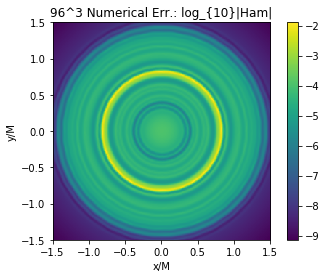

In [24]:
grid96 = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
grid96cub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title("96^3 Numerical Err.: log_{10}|Ham|")
plt.xlabel("x/M")
plt.ylabel("y/M")

fig96cub = plt.imshow(grid96cub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(fig96cub)

Next, we set up the same initial data but on a lower-resolution, $48\times 8\times 2$ grid (axisymmetric in the $\phi$ direction). Since the constraint violation (numerical error associated with the fourth-order-accurate, finite-difference derivatives) should converge to zero with the uniform gridspacing to the fourth power: $\left(\Delta x^i\right)^4$, we expect the constraint violation will increase (relative to the $96\times 16\times 2$ grid) by a factor of $\left(96/48\right)^4$. Here we demonstrate that indeed this order of convergence is observed as expected, *except* in the region causally influenced by the star's surface at $\bar{r}=\bar{R}\approx 0.8$ where the stress-energy tensor $T^{\mu\nu}$ sharply drops to zero.

It: 81 t=0.50 | 100.0%; ETA 0 s | t/h 1469.90 | gp/s 2.04e+05


<Figure size 432x288 with 0 Axes>

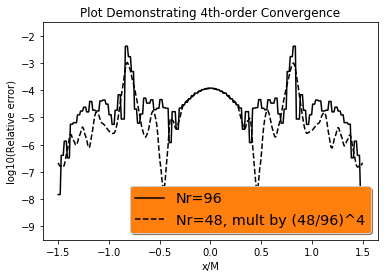

In [25]:
!rm -f out48-00*.txt out48-00*.txt.png
!taskset -c 0,1,2,3 ./TOV_Playground 48 8 2 > out48.txt

x48,y48,valuesother48,valuesHam48 = np.loadtxt('out48.txt').T #Transposed for easier unpacking
points48 = np.zeros((len(x48), 2))
for i in range(len(x48)):
    points48[i][0] = x48[i]
    points48[i][1] = y48[i]

grid48 = griddata(points48, valuesHam48, (grid_x, grid_y), method='cubic')

griddiff_48_minus_96 = np.zeros((N_interp_pts,N_interp_pts))
griddiff_48_minus_96_1darray = np.zeros(N_interp_pts*N_interp_pts)
gridx_1darray_yeq0 = np.zeros(N_interp_pts)
grid48_1darray_yeq0 = np.zeros(N_interp_pts)
grid96_1darray_yeq0 = np.zeros(N_interp_pts)
count = 0
outarray = []
for i in range(N_interp_pts):
    for j in range(N_interp_pts):
        griddiff_48_minus_96[i][j] = grid48[i][j] - grid96[i][j]
        griddiff_48_minus_96_1darray[count] = griddiff_48_minus_96[i][j]
        if j==N_interp_pts/2-1:
            gridx_1darray_yeq0[i] = grid_x[i][j]
            grid48_1darray_yeq0[i] = grid48[i][j] + np.log10((48./96.)**4)
            grid96_1darray_yeq0[i] = grid96[i][j]
        count = count + 1

plt.clf()
fig, ax = plt.subplots()
plt.title("Plot Demonstrating 4th-order Convergence")
plt.xlabel("x/M")
plt.ylabel("log10(Relative error)")

ax.plot(gridx_1darray_yeq0, grid96_1darray_yeq0, 'k-', label='Nr=96')
ax.plot(gridx_1darray_yeq0, grid48_1darray_yeq0, 'k--', label='Nr=48, mult by (48/96)^4')
ax.set_ylim([-9.5,-1.5])

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 9: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [26]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.ipynb
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
!pdflatex -interaction=batchmode Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.ipynb to latex
[NbConvertApp] Writing 197032 bytes to Tutorial-Start_to_Finish-BSSNCurvilinear-Neutron_Star-Hydro_without_Hydro.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
